In [25]:
#import user modules
import utils.helper_functions as hfun
import config as cf
import modules.thouless_times as thouless
import modules.spectral_functions as spec_fun
import modules.sff as sff
import modules.adiabatics as agp
import modules.anderson as anderson
import importlib
def reload_modules():
    importlib.reload(anderson)
    importlib.reload(hfun)
    importlib.reload(cf)
    importlib.reload(thouless)
    importlib.reload(spec_fun)
    importlib.reload(agp)
    importlib.reload(sff)

reload_modules()

from utils.fit_functions import *
#--- importet in user module
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.markers import MarkerStyle
import os
from utils import exit
from os import sep as kPSep
from os.path import exists

#--- other modules
import numpy as np
import itertools
import seaborn as sns
import pandas as pd
import math
import random
import imageio
#import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from joblib import Parallel, delayed
import copy
#plt.style.use(['science','ieee','no-latex'])

# get all the colors
import matplotlib.colors as mcolors
from scipy.special import binom
import sympy as sym
from scipy.optimize import curve_fit as fit

print(cf.base_directory)
from cmath import nan


user_settings = getattr(cf.plot_settings, 'settings')

../results/HEISENBERG/disorder/PBC/


### GAP RATIO AND CHAOTIC STATISTICS

0.02 1.026451461130746 0.2024533557366743
0.04 1.04873887648906 0.17721437323536846
0.06 1.039064400367548 0.20432836089690826
0.08 1.028362025275612 0.2326821423605985
0.1 1.019674706484993 0.2568452893887646
0.12000000000000001 1.0150098029405823 0.2706376078402643
0.13999999999999999 1.011534981095786 0.2812190593835262
0.16 1.0093969270193905 0.2878970074751772
0.18 1.007656056762906 0.293264368467789
0.19999999999999998 1.0066726996912079 0.29627352049333966
0.22 1.0057661072968433 0.2988804771122088
0.24 1.005169771704183 0.30048813216685094
0.26 1.00503308843851 0.3007348177057977
0.28 1.00434612295405 0.3023875349916684
0.30000000000000004 1.0039652648500919 0.30307088906645324
0.32 1.0034932450445484 0.3039274415496566
0.34 1.0039355158011005 0.30215717530534014
0.36000000000000004 1.0036184908013197 0.302356917432708
0.38 1.0038008851233533 0.30127983586089413
0.4 1.00468278460321 0.298109331441573
0.42000000000000004 1.0025000906283852 0.3031676094745308
0.44 1.0048041172707

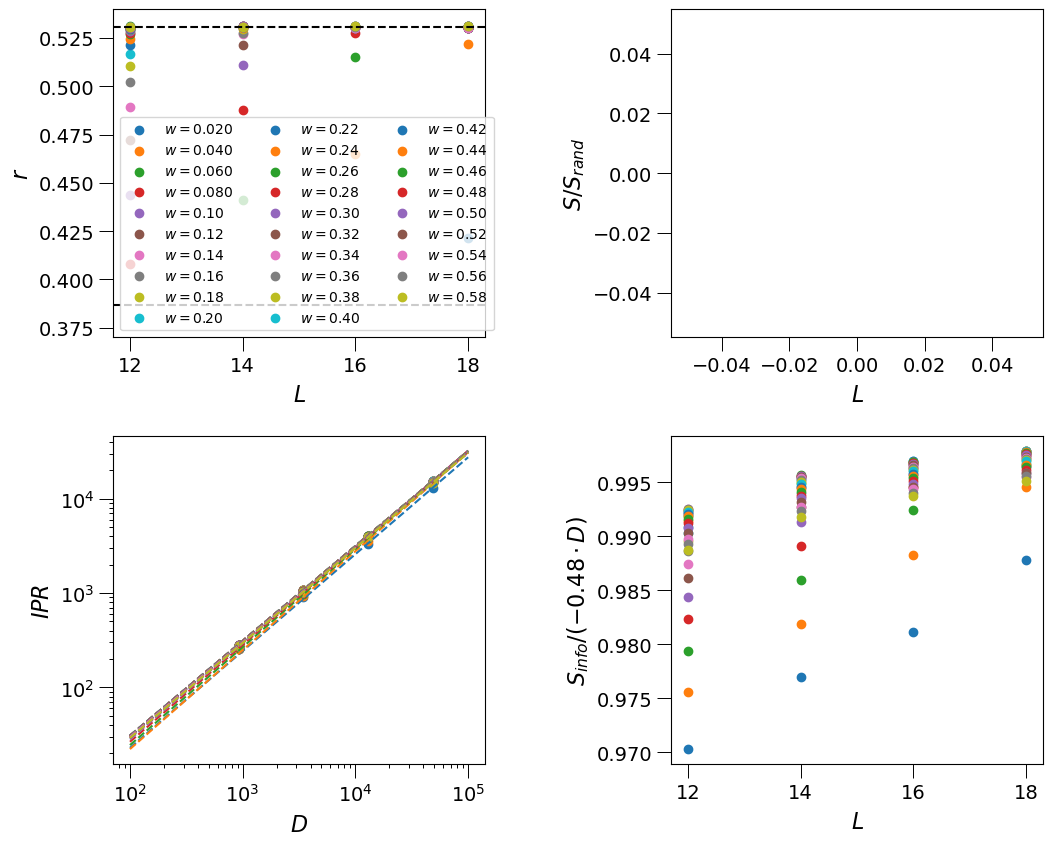

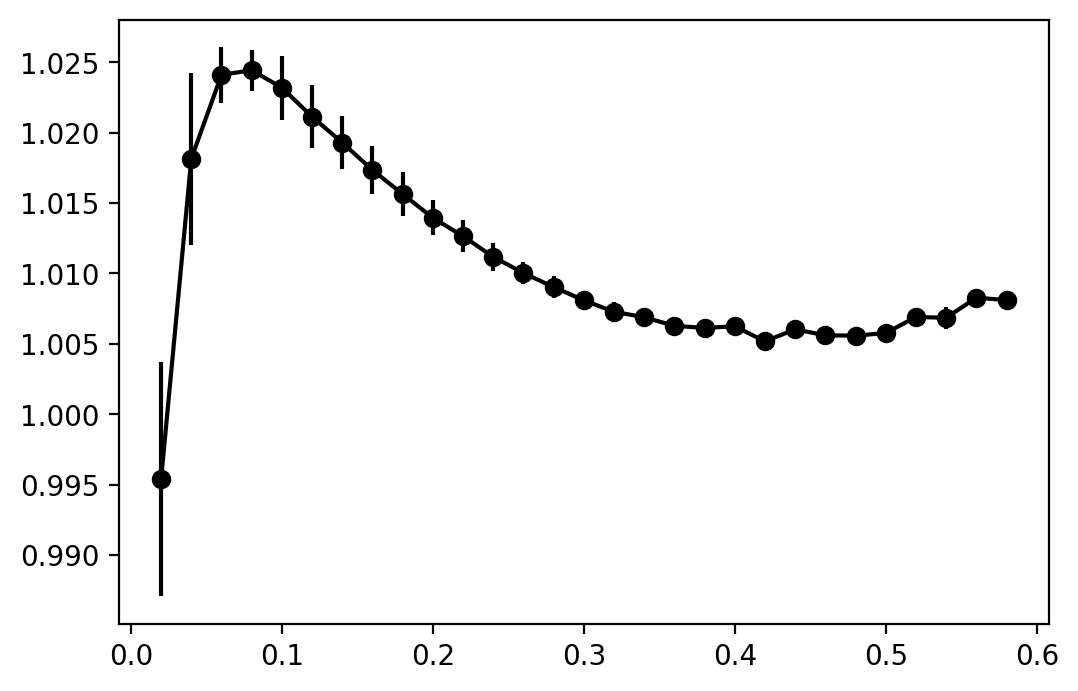

In [77]:
reload_modules()
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots( nrows=2, ncols=2, figsize=(12,10), dpi = 100)

new_set_class = copy.deepcopy(cf.plot_settings)
new_set_class.set_vs('L')
new_set_class.set_scaling("w")
new_set_class.set_scales(xscale='log', yscale='log')
settings = getattr(new_set_class, 'settings')

alfa = []
error_bars = []

param_copy = copy.deepcopy(cf.params_arr)
vals = None
if settings['scaling_idx'] == 2:
    vals = [0.0011, 0.002, 0.01, 0.042, 0.11, 0.33, 0.44, 0.58]
elif settings['scaling_idx'] == 4:
    vals = [0.04, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
    vals = hfun.get_scaling_array(settings, x0=0.02, xend=0.6, dx=0.02)
else:
    vals = hfun.get_scaling_array(settings)
for x in vals:
    cf.params_arr[settings['scaling_idx']] = x
    filename = cf.base_directory + "STATISTICS" + kPSep + hfun.remove_info(hfun.info_param(cf.params_arr), settings['vs']) + ".dat" 
    if exists(filename):
        Ltmp = x if settings['scaling_idx'] == 0 else cf.L

        #stats = pd.read_table(filename, sep="\t", header=None)
        stats = hfun.read_python_saved_dat_file(filename)
        xdata = stats[0]
        dims = binom(xdata, xdata / 2)
        gap_ratio = stats[1]

        norm = 1.0  if settings['vs_idx'] == 0 else binom(Ltmp, Ltmp / 2.) / np.sqrt(Ltmp)
        wH = stats[5] * norm
        wH_typ = stats[6] * norm
        
        ipr = stats[2] * dims
        info_ent = stats[3]

        pars, pcov = fit(f=power_law, 
                xdata=dims, 
                ydata=ipr)
        print(x, *pars)
        #alfa.append(pars[0])
        alfa.append( np.log2(ipr[-1] / ipr[0]) / np.log2(dims[-1] / dims[0]) )
        error_bars.append(np.sqrt(np.diag(pcov)[0]))

        norm_entropy = Ltmp * np.log(2) / 2. + (0.5 - np.log(2)) / 2. - 0.5
        entropy = stats[4] / norm_entropy
        
        ax1.scatter(xdata, gap_ratio, label=hfun.key_title(x, settings))
        ax2.scatter(xdata, entropy, label=hfun.key_title(x, settings))
        #ax3.scatter(xdata, wH, label=hfun.key_title(x, settings))
        #ax4.scatter(xdata, wH_typ, label=hfun.key_title(x, settings))
        ax3.scatter(dims, ipr, label=hfun.key_title(x, settings))
        aa = np.logspace(2, 5, 100)
        ax3.plot(aa, power_law(aa, *pars), linestyle='--')
        ax4.scatter(xdata, info_ent, label=hfun.key_title(x, settings))
    else:
        print(filename)

def wH_analitycal(L, delta, W):
    """Calculate analytical mean level spacing"""
    width = np.sqrt(L * ( (2. + delta**2) / 16. + W**2 / 12.))
    chi = 0.3413
    dim = binom(L, L/2) if cf.hamiltonian == 1 else 2**L
    return width / (dim * chi)

if False:
    if settings['vs_idx'] != 0:
        xx = np.logspace(-0.5, 0, 100)
        if settings['vs_idx'] == 2:     ax3.plot(xx, binom(cf.L, cf.L/2) / np.sqrt(cf.L) / 1.02 * wH_analitycal(cf.L, xx, cf.w), linestyle='--', color='black', label=r"$\omega_H^{analitycal}$")
        else:                           ax3.plot(xx, binom(cf.L, cf.L/2) / np.sqrt(cf.L) / 1.02 * wH_analitycal(cf.L, cf.g, xx), linestyle='--', color='black', label=r"$\omega_H^{analitycal}$")
        if settings['vs_idx'] == 2:     ax4.plot(xx, binom(cf.L, cf.L/2) / np.sqrt(cf.L) / 1.2 * wH_analitycal(cf.L, xx, cf.w), linestyle='--', color='black', label=r"$\omega_H^{analitycal}$")
        else:                           ax4.plot(xx, binom(cf.L, cf.L/2) / np.sqrt(cf.L) / 1.2 * wH_analitycal(cf.L, cf.g, xx), linestyle='--', color='black', label=r"$\omega_H^{analitycal}$")
    else:
        xx = np.linspace(9, 19, 20)
        ax3.plot(xx, wH_analitycal(xx, cf.g, cf.w), linestyle='--', color='black', label=r"$\omega_H^{analitycal}$")
        ax4.plot(xx, wH_analitycal(xx, cf.g, cf.w), linestyle='--', color='black', label=r"$\omega_H^{analitycal}$")


ax1.axhline(y=0.5307, ls='--', color='black')
ax1.axhline(y=0.3867, ls='--', color='black')
ylabels = ["r", "S/S_{rand}", "\\omega_H\\cdot DL^{-1/2}", "\\omega_H^{typ}\\cdot DL^{-1/2}" ]
ylabels = ["r", "S/S_{rand}", "IPR", "S_{info}/(-0.48\\cdot D)" ]
for i, ax in enumerate([ax1,ax2,ax3,ax4]):
    xlab = hfun.var_name if settings['vs_idx'] == 2 else settings['vs']
    if i == 2: xlab = "D"
    hfun.set_plot_elements(axis = ax, ylabel = ylabels[i], xlabel = xlab, settings=settings, 
                            font_size=14, set_legend=False, xlim=(None, None), ylim=(None, None))
    if settings['vs_idx'] == 0 and i != 2:
        ax.set_yscale('linear')
        ax.set_xscale('linear')
    
ax3.set_xscale('log')
ax4.set_xscale('linear')
ax1.legend(ncol=3)
ax1.set_ylim(0.37, 0.54)
#ax2.set_ylim(0.3, 1)\
fig.subplots_adjust(wspace=0.5, hspace=0.3)

fig, axis = plt.subplots(nrows=1,ncols=1,figsize=(6,4), dpi = 200)
#axis.plot(vals, alfa)
axis.errorbar(vals, alfa, yerr=error_bars, marker='o', color='black')

 #--- reset defaults
cf.params_arr = param_copy

### SPECTRAL FORM FACTOR

_L=14,J=1.00,J0=0.00,g=0.55,g0=0.00,h=0.00,w=0.30.dat [14.0, 1.0, 0.55, 0.0, 0.3, 0, 1, 1, 0.0, 0.0]
_L=14,J=1.00,J0=0.00,g=0.55,g0=0.00,h=0.00,w=0.32.dat [14.0, 1.0, 0.55, 0.0, 0.32, 0, 1, 1, 0.0, 0.0]
_L=14,J=1.00,J0=0.00,g=0.55,g0=0.00,h=0.00,w=0.34.dat [14.0, 1.0, 0.55, 0.0, 0.34, 0, 1, 1, 0.0, 0.0]
_L=14,J=1.00,J0=0.00,g=0.55,g0=0.00,h=0.00,w=0.36.dat [14.0, 1.0, 0.55, 0.0, 0.36, 0, 1, 1, 0.0, 0.0]
_L=14,J=1.00,J0=0.00,g=0.55,g0=0.00,h=0.00,w=0.38.dat [14.0, 1.0, 0.55, 0.0, 0.38, 0, 1, 1, 0.0, 0.0]
_L=14,J=1.00,J0=0.00,g=0.55,g0=0.00,h=0.00,w=0.40.dat [14.0, 1.0, 0.55, 0.0, 0.4, 0, 1, 1, 0.0, 0.0]
_L=14,J=1.00,J0=0.00,g=0.55,g0=0.00,h=0.00,w=0.42.dat [14.0, 1.0, 0.55, 0.0, 0.42, 0, 1, 1, 0.0, 0.0]
_L=14,J=1.00,J0=0.00,g=0.55,g0=0.00,h=0.00,w=0.44.dat [14.0, 1.0, 0.55, 0.0, 0.44, 0, 1, 1, 0.0, 0.0]
_L=14,J=1.00,J0=0.00,g=0.55,g0=0.00,h=0.00,w=0.46.dat [14.0, 1.0, 0.55, 0.0, 0.46, 0, 1, 1, 0.0, 0.0]
_L=14,J=1.00,J0=0.00,g=0.55,g0=0.00,h=0.00,w=0.48.dat [14.0, 1.0, 0.55, 0.0, 0.48, 0

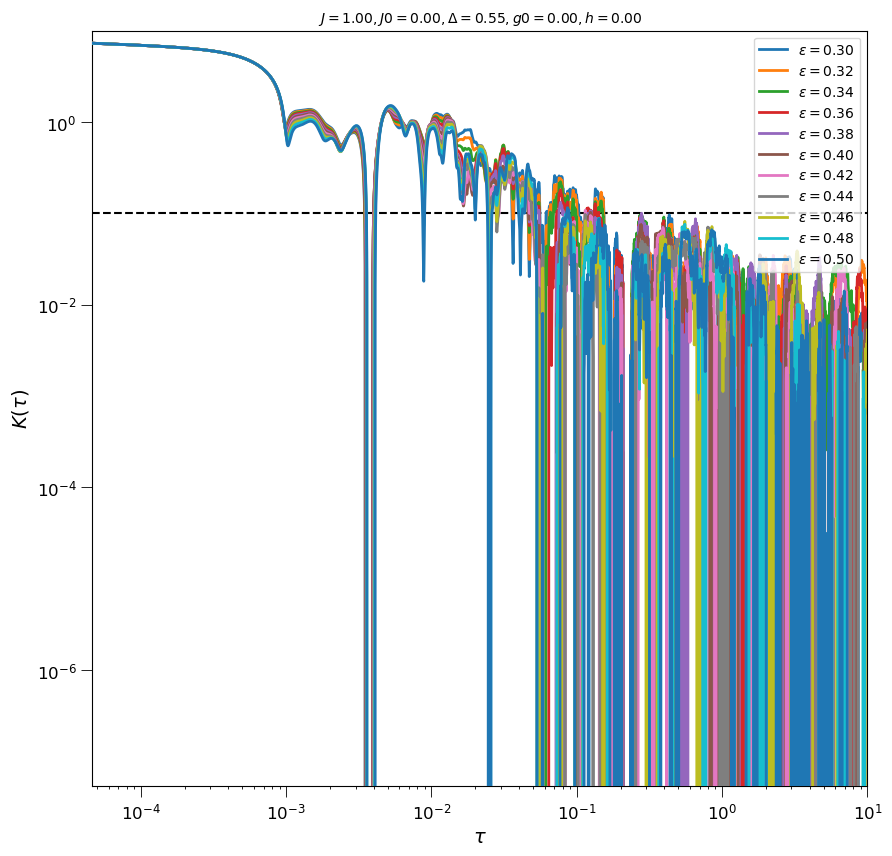

In [112]:
reload_modules()
fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(10,10), dpi = 100)
vals_sff = hfun.get_scaling_array(user_settings, 0.3, 0.5, 0.02)
  
plot_deviation = 1

if plot_deviation:
    sff.plot_deviation(axis=axis, vals=vals_sff)
else:
    axis.grid(b=True, which='major', color='0.65', linestyle='-')
    axis.grid(b=True, which='minor', color='0.85', linestyle='--')
    
    left, bottom, width, height = [0.53, 0.5, 0.35, 0.35]
    axis2 = fig.add_axes([left, bottom, width, height])
    
    sff.plot(axis=axis, vals=vals_sff, axis_inset=axis2, func_x = lambda x, a: x * 1**2)

# PLOT SPECTRAL FUNCTIONS

### PREAMBLE

In [2]:
# SET LEGEND FUNCTION

from matplotlib.lines import Line2D
def add_legend(axis):
    legend = axis.legend()
    #ax = legend.axes

    handles, labels = axis.get_legend_handles_labels()
    if user_settings['scaling'] == 'k':
        new_lab = []
        for label in labels:
            label = list(label)
            label[1] = 'q'
            new_lab.append("".join(label))
        labels = new_lab
    handles.append(Line2D([0], [0], linewidth=1, linestyle='--', marker='o', color='black'));   labels.append(r"$\omega_H$")
    handles.append(Line2D([0], [0], linewidth=1, linestyle='--', marker='o', color='black', markerfacecolor='None'));   labels.append(r"$\omega^{typ}_H$")
    #handles.append(Line2D([0], [0], linewidth=1, linestyle='--', marker='s', color='black'));   labels.append(r"$\omega_{Th}$")

    legend._legend_box = None
    legend._init_legend_box(handles, labels)
    legend._set_loc(legend._loc)
    legend.set_title(legend.get_title().get_text())
    axis.legend(handles, labels, frameon=False, loc='best', fontsize=10)




use_derivative = 0
time_dir = cf.base_directory + "timeEvolution%s"%kPSep
int_dir = cf.base_directory + "IntegratedResponseFunction%s"%kPSep
spec_dir = cf.base_directory + ("IntegratedResponseFunction%sDERIVATIVE%s"%(kPSep,kPSep) if use_derivative else "ResponseFunction%s"%kPSep)

## MAIN SPECTRALS

[0.2 0.3 0.4 0.5 0.6 0.7 0.8]
[12 14 16 18]
Pandas broke down
Pandas broke down
Pandas broke down
Pandas broke down


(0.1, 100.0)

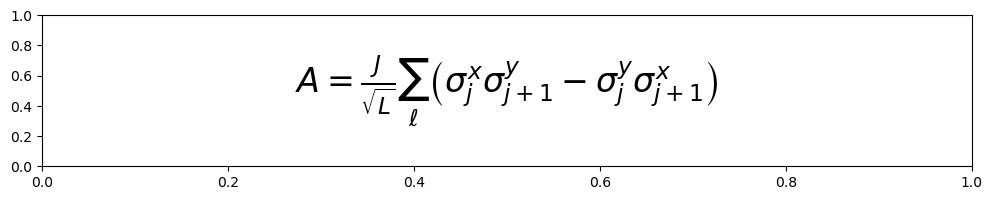

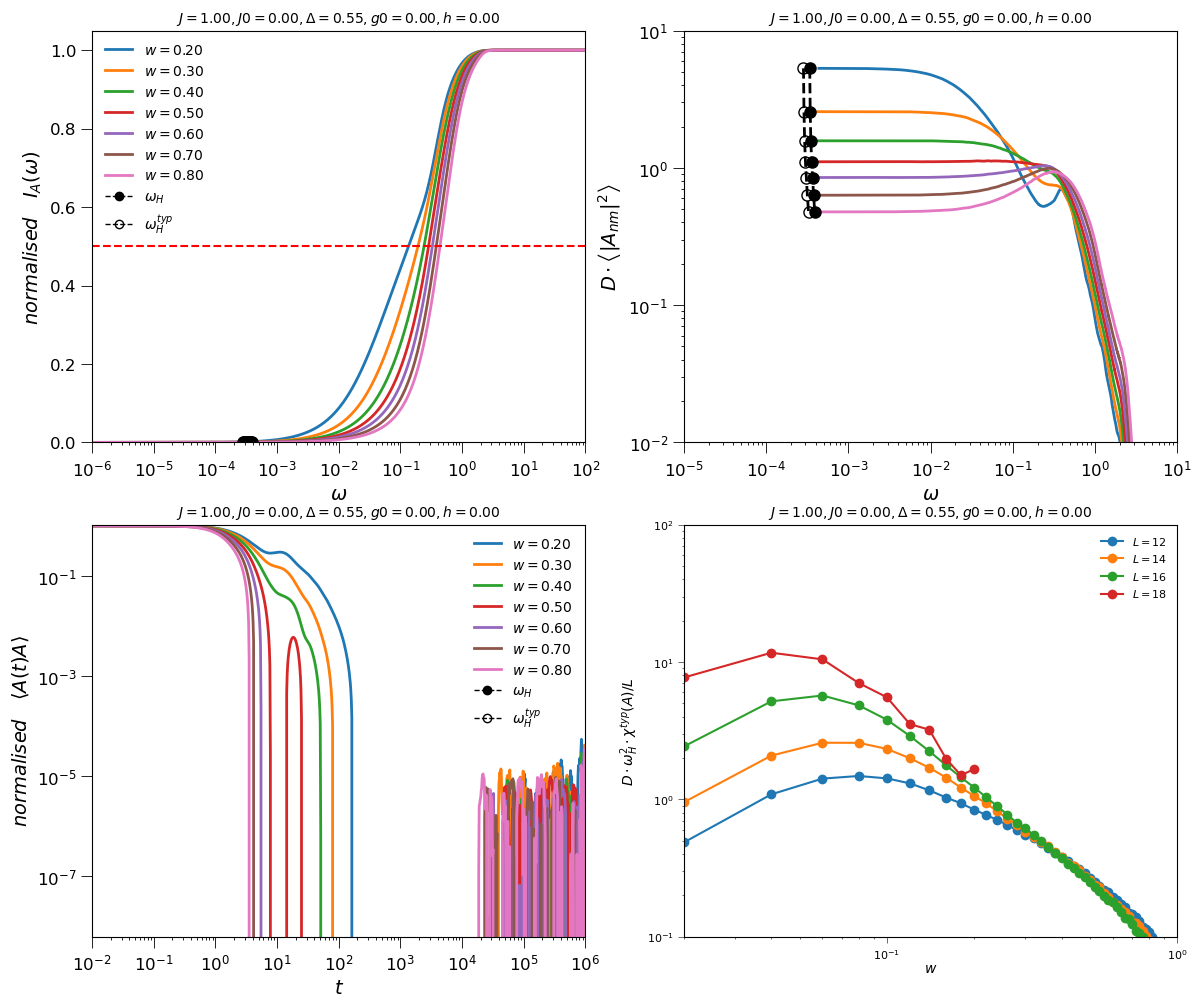

In [63]:

reload_modules()
x0 = 0.2
xend = 0.8
dx = 0.1
vals = hfun.get_scaling_array(user_settings, x0, xend, dx)
print(vals)
fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(12,2), dpi = 100)
axis.annotate(r"$A=$"+cf.operator_formuals[user_settings['operator']], xy=(0.5, 0.5), color='black', size=24, ha='center', va='center')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots( nrows=2, ncols=2, figsize=(14,12), dpi = 100)
func_t = lambda y, x: y #* x**2
func_w = lambda y, x: y #/ x**2

#---------------------- TIME EVOLUTION
spec_fun.plot_spectral(axis = ax3, settings=user_settings, vals = vals,
                        xlab="t", ylab="\\langle A(t)A\\rangle", 
                        xscale='log',yscale='log', normalise=True, 
                        spec="time", func_x=func_t)
add_legend(axis=ax3)
#ax3.set_ylim(-0.1,1)
#ax3.set_xlim(0,2e2)
#---------------------- INTEGRATED SPECTRAL FUNCTION
spec_fun.plot_spectral(axis = ax1, settings=user_settings, vals = vals,
                        xlab="\\omega", ylab="I_A(\\omega)", 
                        yscale='linear', normalise=True, 
                        spec="int", func_x=func_w)
add_legend(axis=ax1)
ax1.axhline(y=0.5, ls='--', color='red')
#ax1.legend(title=r"$A=H_{q=1}$")
ax1.set_ylim(0,1.05)

#---------------------- SPECTRAL FUNCTION
spec_fun.plot_spectral(axis = ax2, settings=user_settings, vals = vals,
                        xlab="\\omega", ylab="D\\cdot\\left\\langle|A_{nm}|^2\\right\\rangle", 
                        xscale='log', yscale='log', func_x=func_w, 
                        spec="spec", use_derivative=use_derivative)
if use_derivative: ax2.set_ylim(5e-30, 1e3)
else: ax2.set_ylim(1e-2, 1e1)
ax2.set_xlim(1e-5, 1e1)
#add_legend(axis=ax2)
xval=np.logspace(-6,1,100)
#ax2.plot(xval, 0.38+2*xval, linestyle='--', color='black')
#ax2.plot(xval, 3e0/xval, linestyle='--', color='black')
#ax2.plot(xval, 3e0/xval**2, linestyle='--', color='red')



#---------------------- ADIABATICS
new_set_class = copy.deepcopy(cf.plot_settings)
new_set_class.set_vs(cf.plot_settings.settings['scaling'])
new_set_class.set_scaling("L")
new_set_class._settings['site'] = -1
new_set_class.set_scales(xscale='log', yscale='log')
agp.plot_agp(axis = ax4, settings_class=new_set_class, which=2, operator=user_settings['operator'], site=-1)
ax4.set_ylim(1e-1, 1e2)


## SPECTRAL FUNCTION WITH RELAXATION TIME

No Thouless data present
No data


(100.0, 100000.0)

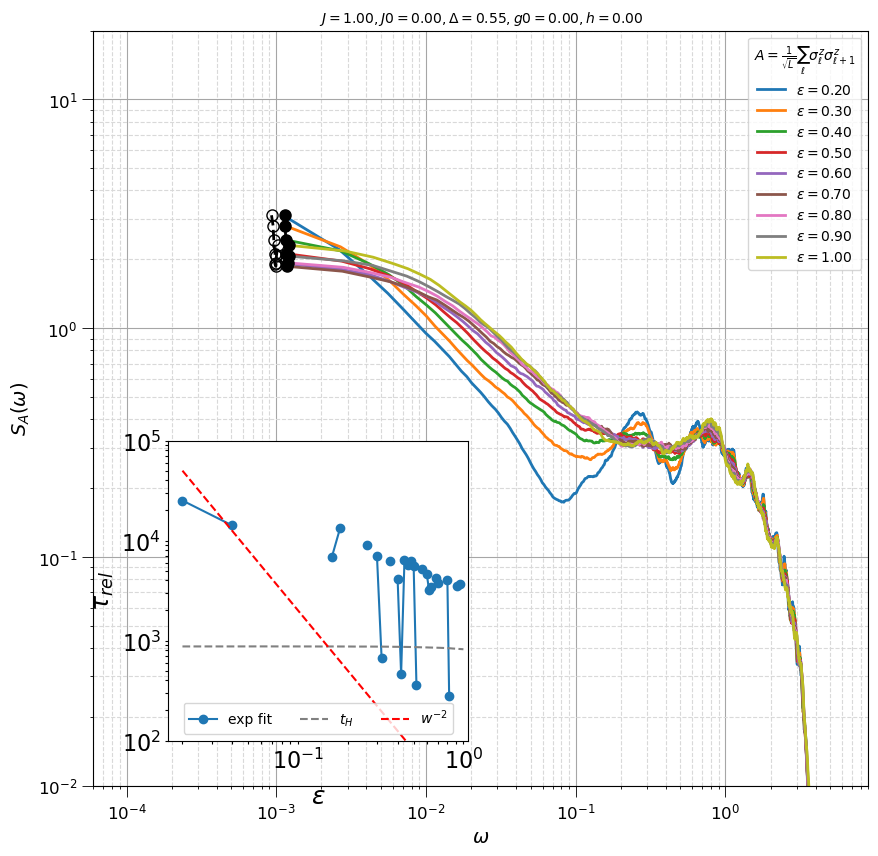

In [115]:
reload_modules()

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(10,10), dpi = 100)

func = lambda y, x: y #* x**1.33

vals_spec = hfun.get_scaling_array(user_settings, 0.2, 1.02, 0.1)

spec_fun.plot_spectral(axis = axis, settings=user_settings, vals = vals_spec, 
                        xlab="\\omega", ylab="S_A(\\omega)", yscale='log', xscale='log', 
                        normalise=False, spec="spec", func_x=func, 
                        use_derivative=use_derivative)
add_legend(axis=axis)
addition = r"$\quad j=\frac{L}{2}$" if user_settings['operator'] < 8 else ""
try:
    idx = (cf.operator_formuals[user_settings['operator']][2:]).index("=")
    leg = axis.legend(title=r"$A=$"+cf.operator_formuals[user_settings['operator']][0:idx] + "$" + addition, loc='upper right')
except ValueError:
    leg = axis.legend(title=r"$A=$"+cf.operator_formuals[user_settings['operator']] + addition, loc='upper right')

axis.grid(b=True, which='major', color='0.65', linestyle='-')
axis.grid(b=True, which='minor', color='0.85', linestyle='--')
axis.set_ylim(1e-2, 2e1)
axis.set_xlim(6e-5, 9e0)
#leg = axis.legend(title=r"$A=J^s_{cur}$", fontsize=18, loc='lower right')
#leg.get_title().set_fontsize('18')
#axis.title.set_text("")

ii = user_settings['scaling_idx']
xlab = "q/\\pi" if ii == 5 else (hfun.var_name if ii == 2 else user_settings['scaling'])

left, bottom, width, height = [0.2, 0.17, 0.3, 0.3]
axis2 = fig.add_axes([left, bottom, width, height])
vals = hfun.get_scaling_array(settings=user_settings, 
                                    x0=0.00, 
                                    xend=1.02, 
                                    dx=0.02)

status_time, taus, relax_time, relaxt_time_fit, tH, tH_typ, gap_ratio = spec_fun.get_relax_times(vals=vals)

trueQ = 2 * vals / cf.L if user_settings['scaling_idx'] == 5 else vals    
spec_fun.set_inset(axis2, user_settings, trueQ, taus, relax_time, relaxt_time_fit, tH, tH_typ, status_time)
axis2.set_ylim(1e2,1e5)

#fig, (ax1, ax2) = plt.subplots( nrows=1, ncols=2, figsize=(14,8), dpi = 100)
#spec_fun.set_inset(ax1, user_settings, vals, taus, relax_time, relaxt_time_fit, tH, tH_typ, status_time)
#ax2.plot(trueQ, relaxt_time_fit / taus, marker='o')
#ax2.plot(trueQ, 11. * (1.0 - 0.03 / trueQ)**2, linestyle='--', label=r"$\left( 1 - \frac{%s_c}{%s}\right)^2$"%(xlab, xlab))
#spec_fun.set_inset_style(axis = ax2, 
#                vals = vals, 
#                settings = user_settings,
#                ylim = (2, 15),
#                ylabel = "\\tau_{rel}/\\tau_{Th}")
#ax2.set_xscale('linear')
#ax2.set_yscale('linear')

$$\tau_{Th}\sim \left(\Delta-\Delta_c\right)^{-2}$$

$$\tau_{rel}^{\sigma^z_j={L/2}}\sim \Delta^{-2}$$

$$ \frac{\tau_{rel}^{\sigma^z_j={L/2}}}{\tau_{Th}}\sim\left(1-\frac{\Delta_c}{\Delta}\right)^2$$

$$\langle H \sigma^z_{j=L/2}\rangle=?$$

In [116]:
from multiprocessing.sharedctypes import Value


status_time, xvalues, taus, gap_ratio = spec_fun.get_thouless_time(par = cf.L, set_class=new_set_class)
vals_spec = hfun.get_scaling_array(user_settings)

" Find thouless data "
tau_data = []
try :
    valsup = hfun.get_scaling_array(settings=user_settings, x0=0.1, dx=0.02, xend=1.0)
    tau_data = thouless.load(settings=user_settings, vals=valsup)
except OSError:
    print("No Thouless data present") 
exponent = []
error_bars = []
for i in  range(len(tau_data[0])):
    pars = [0,0]
    try:
        pars, pcov = fit(f=power_law, 
                        xdata=tau_data[1][i][1:], 
                        ydata=tau_data[2][i][1:])
    except RuntimeError as error:
        print(error)
    exponent.append(pars[0])
    error_bars.append(np.sqrt(np.diag(pcov)[0]))

error_bars = np.array(error_bars)
ii = user_settings['scaling_idx']
xlab = "q/\\pi" if ii == 5 else (hfun.var_name if ii == 2 else user_settings['scaling'])



fig, (ax1, ax2) = plt.subplots( nrows=1, ncols=2, figsize=(14,6), dpi = 100)
ax1_2 = ax1.twinx()
#ax.plot(tau_data[0], exponent, marker='o')
ax1.errorbar(tau_data[0], exponent, yerr=error_bars, marker='o', color='black')

if user_settings['scaling_idx'] == 2:
    try:
        idx = list(tau_data[0]).index(cf.g)
        ax1.plot([tau_data[0][idx], tau_data[0][idx]], [0.0, exponent[idx]], color='black', linestyle='--', marker='o')
    except ValueError:
        print(r"$\Delta=0.55$" + f" not found")
ax1_2.plot(xvalues, gap_ratio, marker='o', linestyle='--', color='red')
ax1_2.set_ylim(0.38, 0.54)
ax1_2.set_ylabel(r"$\langle r\rangle_E$", color='red', fontsize=12)
ax1_2.tick_params(axis='y', color='red', labelcolor='red')

spec_fun.set_inset_style(axis = ax1, 
                vals = tau_data[0], 
                settings = user_settings,
                ylim = (0, 4),
                ylabel = "\\alpha_{Th}")
ax1.set_xscale('linear')
ax1.set_yscale('linear')
ax1.set_xlim(0.0, None)
ax1.axhline(y=2.0, linestyle='--', color='blue')

pars = [0.3, 0.4, 0.46, 0.55, 0.6, 0.7, 0.8, 0.9, 1.0] \
        if user_settings['scaling_idx'] == 2 else [0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 1.0]
for i in range(len(tau_data[0])):  tau_data[0][i] = round(tau_data[0][i], 3)

for xxx in pars:
    try:
        idx = list(tau_data[0]).index(xxx)
        ax2.plot(tau_data[1][idx], tau_data[2][idx], linestyle='--', marker='o', label=hfun.key_title(x=xxx, settings=user_settings) )
    except ValueError:
        print(r"$\Delta=%.2f$"%xxx + f" not found")


hfun.set_plot_elements(axis = ax2, xlim = (9, 19), 
                            ylim = (None, 3e1), ylabel = "\\tau_{Th}", xlabel = "L", 
                            font_size=12, set_legend=True)
ax2.set_xscale('log')
ax2.set_yscale('log')
x=tau_data[1][0]
#ax2.plot(x, 2.5*(x/10.)**(3), color='red', label=r"$%s^{3}$"%xlab)
ax2.plot(x, 3.5*(x/10.)**(3), color='black', label=r"$%s^{3}$"%xlab)

ax2.legend()

fig.subplots_adjust(wspace=0.4)
print(1./0.)

No Thouless data present
No Thouless data present


IndexError: list index out of range

## SHOW FIT AND RELAX TIME PLOT

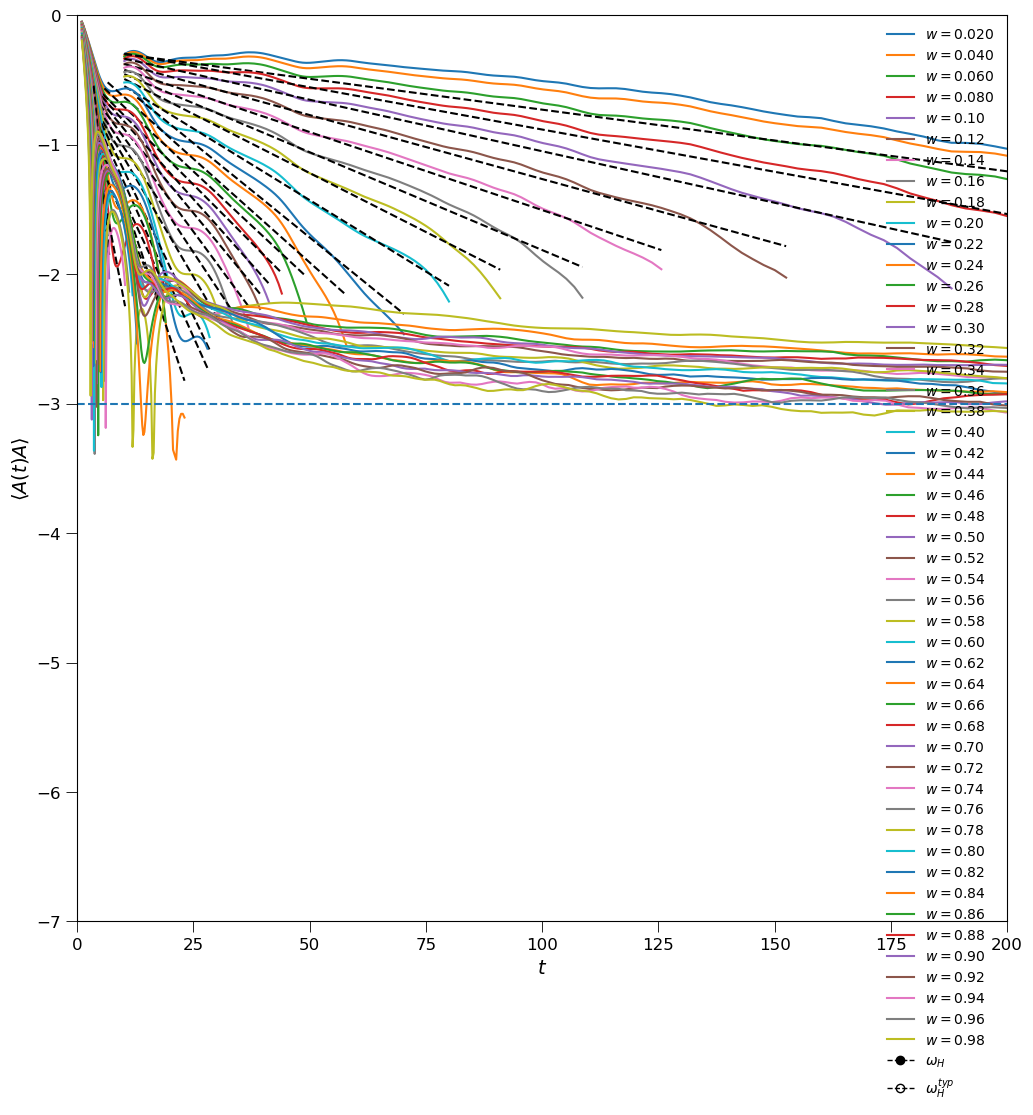

In [61]:
reload_modules()

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(12,12), dpi = 100)

func = lambda y, x: y# * x**1.33

xxx = 0.02

vals = hfun.get_scaling_array(settings=user_settings, 
                                    x0=0.02, 
                                    xend=0.99, 
                                    dx=0.02)
#---------------------- TIME EVOLUTION
#spec_fun.plot_spectral(axis = axis, settings=user_settings, vals = vals,
#                        xlab="t", ylab="\\langle A(t)A\\rangle", 
#                        yscale='linear', normalise=True, 
#                        spec="time", func_x=func)


relaxt_time_fit = []
relaxt_time_approx = []
tH = []
tH_typ = []
for i in range(0, len(vals)):
    x = vals[i]
    status, xdata, ydata, wHnow, wHtypnow = spec_fun.load_spectral(dir=time_dir, 
                                                                    settings=user_settings, 
                                                                    parameter=x,
                                                                    spec="time",
                                                                    normalise=True
                                                                    )
    if status:
        idx = xover_from_above(ydata, 1e-3)
        relaxt_time_approx.append(xdata[idx])
        xfull = xdata
        ydata = np.log10(np.abs(ydata))
        cut = 1
        if x <= 0.2: cut = 10
        xdata = np.array([xdata[i] for i in range(0,len(xdata)) if (xdata[i] < 1000 and xdata[i] > cut)])
        ydata = np.array([ydata[i] for i in range(0,len(ydata)) if (xfull[i] < 1000 and xfull[i] > cut)])
        
        idx_zero = np.argmin((ydata))
        ydata = ydata[:idx_zero - 5]
        xdata = xdata[:idx_zero - 5]
        xdata = np.array([xdata[i] for i in range(0,len(xdata)) if (ydata[i] > -4.6)])
        ydata = np.array([ydata[i] for i in range(0,len(ydata)) if (ydata[i] > -4.6)])
        #
        axis.plot(xdata, ydata, label=hfun.key_title(x, user_settings))

        #idx = np.where(ydata == np.amin(ydata))
        #print(idx)
        xfull = xdata
        xdata = np.array([xdata[i] for i in range(0,len(xdata)) if (ydata[i] < (-0.6 if x > 0.2 else -0.1))])
        ydata = np.array([ydata[i] for i in range(0,len(ydata)) if (ydata[i] < (-0.6 if x > 0.2 else -0.1))])
        #print(pars2
        tH.append(wHnow)
        tH_typ.append(wHtypnow)
        pars, pcov = fit(f=lin_fit, 
                            xdata=xdata, 
                            ydata=ydata)
        
        if any((np.diag(pcov)) / pars > 0.1):
            relaxt_time_fit.append(nan)
        else:
            relaxt_time_fit.append(pars[0])
            axis.plot(xdata, lin_fit(xdata, *pars), linestyle='--', color='black')
    else:
        tH.append(nan)
        tH_typ.append(nan)
        relaxt_time_fit.append(nan)
        relaxt_time_approx.append(nan)

#
hfun.set_plot_elements(axis = axis, xlim = (None, None), 
                                    ylim = (None, None), ylabel = "\\langle A(t)A\\rangle", xlabel = "t", settings=user_settings, font_size=12, set_legend=True)
  
axis.set_xscale('linear')
axis.set_yscale('linear')
axis.axhline(y=-3, linestyle='--')
axis.set_xlim(0,2e2)
axis.set_ylim(-7,0)
add_legend(axis=axis)
#relaxt_time_fit = 1.0 / np.array(relaxt_time_fit)
tH = np.array(tH)
tH_typ = np.array(tH_typ)

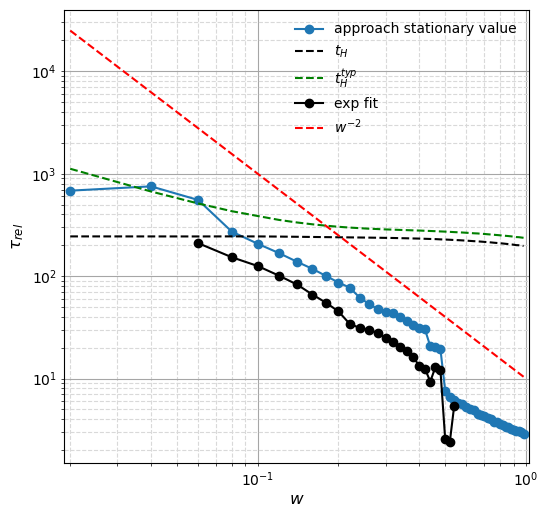

In [62]:

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(6,6), dpi = 100)

xlab = "q/\\pi" if user_settings['scaling_idx'] == 5 else user_settings['scaling']

xrescale = lambda x: x
axis.plot(xrescale(vals), relaxt_time_approx, marker='o', label = 'approach stationary value')

axis.plot(xrescale(vals), tH, linestyle='--', color = 'black', label = r"$t_H$")
axis.plot(xrescale(vals), tH_typ, linestyle='--', color = 'green', label = r"$t_H^{typ}$")
axis.plot(xrescale(vals), relaxt_time_fit, marker='o', color = 'black', label = 'exp fit')

axis.plot(xrescale(vals), 1e1/vals**2, linestyle='--', color='red', label=r"$w^{-2}$")

#if status and user_settings['scaling_idx'] == 5: 
#    axis.axhline(y=taus[0], ls='--', color='black')
#    axis.annotate("$\it{Thouless}\ \it{Time}$", xy=(0.3,1.5e3), color='black', size=12)
#else: 
#    if status == False or cf.model == 2: print('No data')
#    else: axis.plot(vals, taus, linestyle='--', color='black', label=r"$\tau_{Th}$")

hfun.set_plot_elements(axis = axis, xlim = (0.95*min(xrescale(vals)), 1.05*max(xrescale(vals))), 
                                    ylim = (None, None),ylabel = "\\tau_{rel}", xlabel = xlab, settings=user_settings, font_size=10, set_legend=True)
  
axis.set_yscale('log')
axis.set_xscale('log')
axis.tick_params(axis='both', which='both',length=2)
axis.grid(b=True, which='major', color='0.65', linestyle='-')
axis.grid(b=True, which='minor', color='0.85', linestyle='--')


## COMPARE FUNCTIONS

### LONG $\omega$ tail

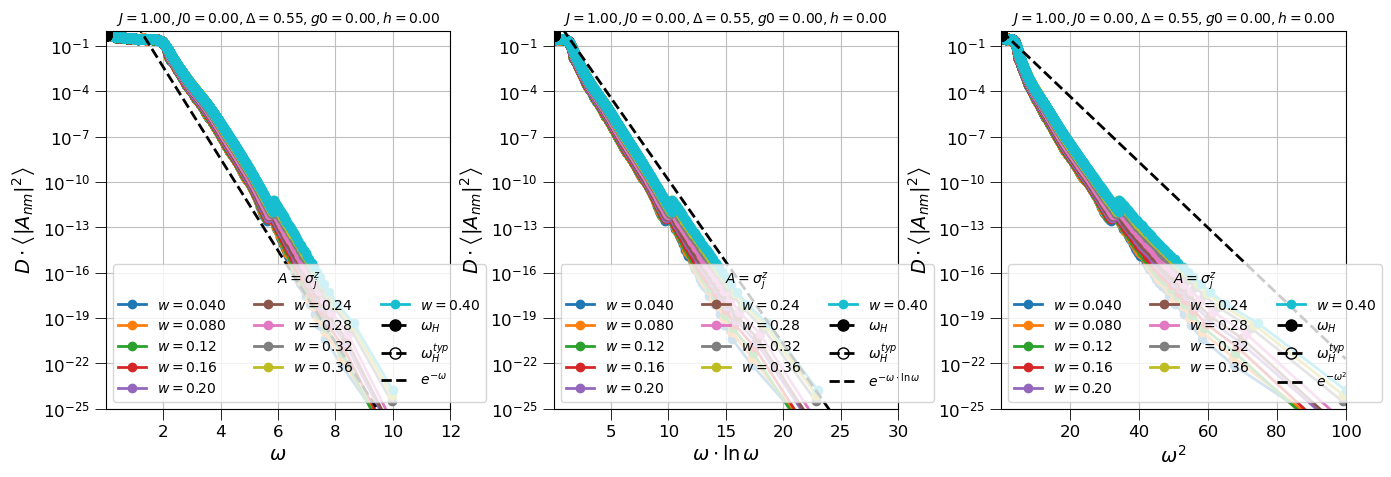

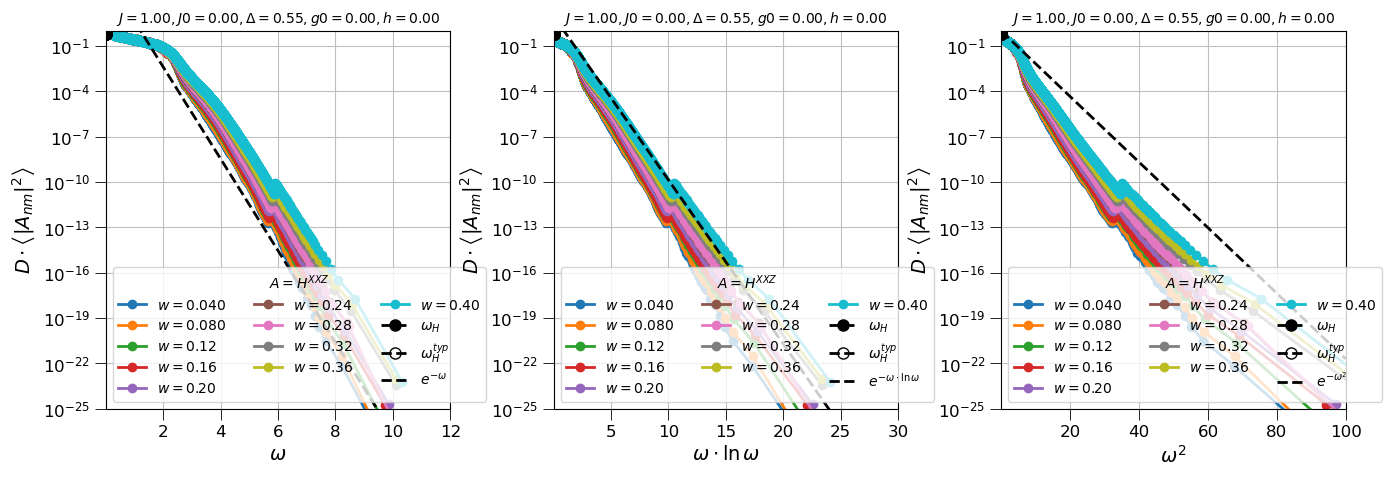

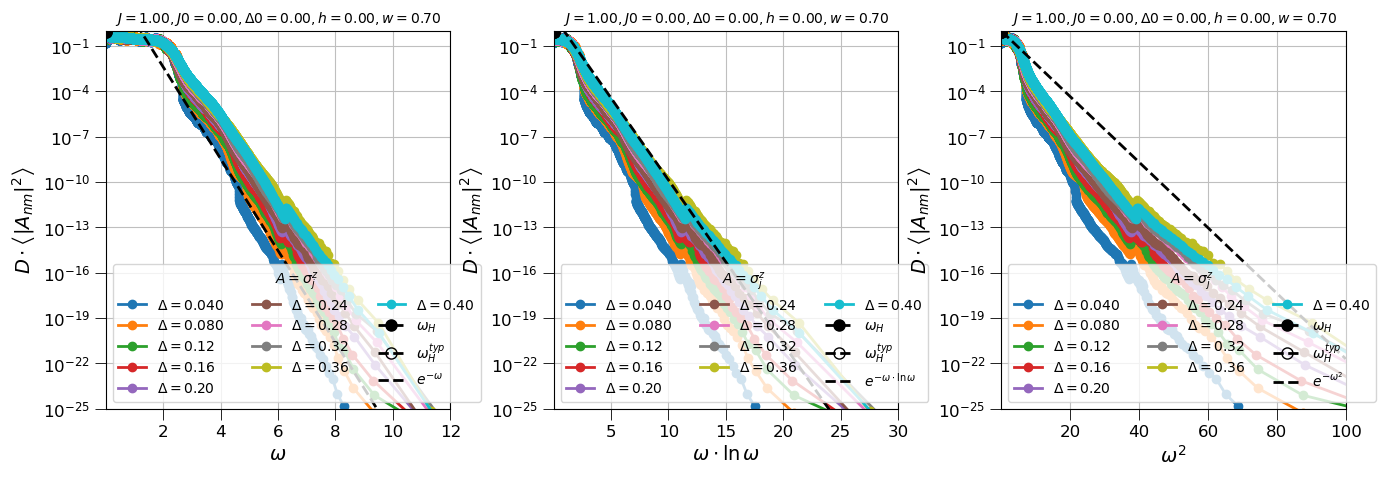

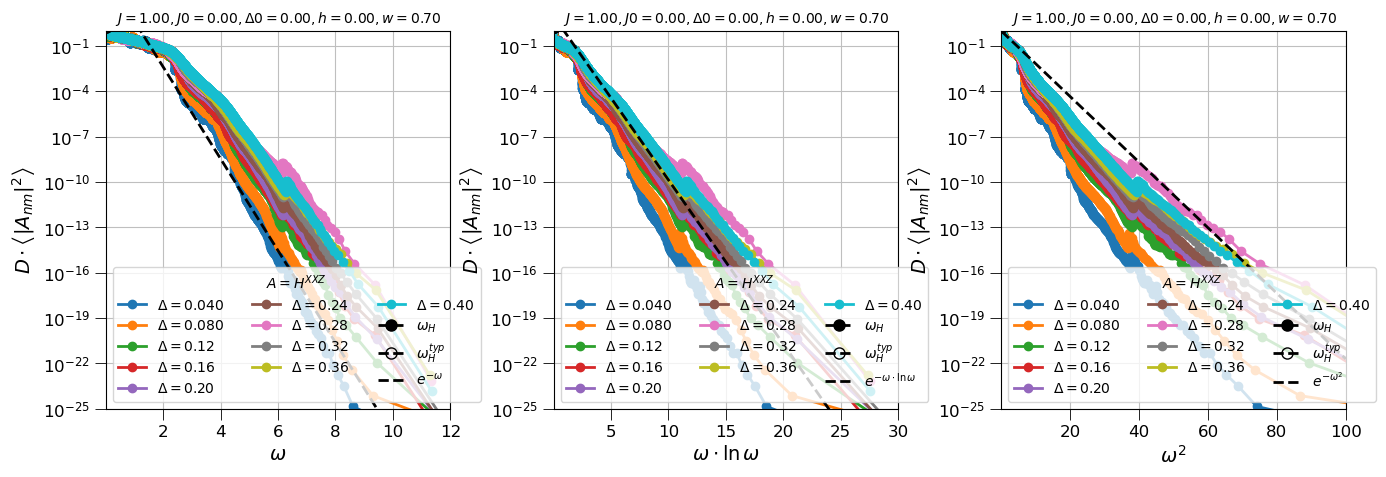

In [ ]:
reload_modules()
def temporary_plot_spec_tail(operatorr, settings):
    fig, axes = plt.subplots( nrows=1, ncols=3, figsize=(16,5), dpi = 100)
    fig.subplots_adjust(wspace=0.3, hspace=0.3)
    wH = [];    LTA = []
    wH_typ = [];    val_at_typ = [];
    omegas = np.logspace(-5, 0, 1000)
    funcs = [lambda x: x, lambda x: x * np.log(x), lambda x: x**2]
    funclabels = ["\\omega", "\\omega\\cdot\\ln\\omega", "\\omega^2"]
    
    for i, func_tail in enumerate(funcs):
        axis = axes[i]
        for x in vals:                    
            status, xdata, ydata, wHnow, wHtypnow = spec_fun.load_spectral(dir=spec_dir, 
                                                            settings=settings, 
                                                            parameter=x,
                                                            spec="spec",
                                                            func_x=lambda x, a: x,
                                                            operator = operatorr,
                                                            site = cf.L/2
                                                            )
            if status:
                ydata = ydata * (2**x / x if settings['scaling_idx'] == 0 else 2**cf.L / cf.L) # rescale by D                                                    
                if wHnow is None or np.isnan(wHnow):
                        wHnow = 1e-5
                        wHtypnow = 1e-6
                p = axis.plot(func_tail(xdata), ydata,label=hfun.key_title(x, settings), linewidth=2, markersize=6, marker='o')
                "mean";     wH.append(wHnow);           idx = min(range(len(xdata)), key=lambda i: abs(xdata[i] - wHnow));     LTA.append(ydata[idx])
                "typical";  wH_typ.append(wHtypnow);    idx = min(range(len(xdata)), key=lambda i: abs(xdata[i] - wHtypnow));  val_at_typ.append(ydata[idx])

        #axis.plot(omegas, 0.4 / (omegas)**0.5, linestyle='--', color='red', label=r"$\omega^{-0.5}$") 
        #axis.plot(omegas, 0.1 / (omegas)**0.75, linestyle='--', color='black', label=r"$\omega^{-0.75}$")        
        hfun.set_plot_elements(axis = axis, ylabel = "D\\cdot\\left\\langle|A_{nm}|^2\\right\\rangle", xlabel = funclabels[i], settings=settings, font_size=12, set_legend=False, xlim=(None, None), ylim=(None, None))
        axis.set_xscale('linear')
        axis.set_yscale('log')
        x_min = 0.5 * np.min(wH_typ)
        axis.set_xlim(x_min, [12, 30, 100][i])
        axis.set_ylim(1e-25, 1e0)
        axis.grid(b=True, which='major', color='0.75', linestyle='-')
        axis.grid(b=True, which='minor', color='0.85', linestyle='--')
        #add_legend(axis=axis)

        axis.plot(wH, LTA, linestyle='--', marker='o', color='black', linewidth=2, markersize=8, label=r"$\omega_H$")
        axis.plot(wH_typ, val_at_typ, linestyle='--', marker='o', color='black', markerfacecolor='None', linewidth=2, markersize=8, label=r"$\omega_H^{typ}$")
        xxxx = np.linspace(0,100,100)
        a = [7, 2.5, 0.5]
        amp = [5e3, 1e1, 1e0]
        axis.plot(xxxx, amp[i] * np.exp(-a[i] * (xxxx)), linestyle='--', color='black', linewidth=2, label=r"$e^{-%s}$"%funclabels[i])
        try:
            idx = (cf.operator_formuals[operatorr][2:]).index("=")
            leg = axis.legend(title=r"$A=$"+cf.operator_formuals[operatorr][0:idx] + "$", loc='lower left', ncol=3)
        except ValueError:
            leg = axis.legend(title=r"$A=$"+cf.operator_formuals[operatorr], loc='lower left', ncol=3)

        title = ""
        if (settings['vs_idx'] == 3 or settings['scaling_idx'] == 3) and cf.J0 == 0 and cf.g0 == 0 and cf.h != 0:
            title = hfun.remove_info(hfun.info_param(cf.params_arr), settings['vs'], settings['scaling'], 'w') + ',w=0.5h'
        else :
            title = hfun.remove_info(hfun.info_param(cf.params_arr), settings['vs'], settings['scaling'])
        if settings['vs_idx'] != 2 :
            try : 
                title = list(title);    title[title.index('g')] = hfun.var_name;   title = "".join(title) # g
            except ValueError:
                    print("not found")
        axis.title.set_text(r"$%s$"%title[1:])
        axis.title.set_fontsize(10)

cf.set_params(_g=0.55)
temporary_plot_spec_tail(operatorr=0, settings=user_settings)
temporary_plot_spec_tail(operatorr=2, settings=user_settings)

cf.set_params(_w=0.7)
new_set_class = copy.deepcopy(cf.plot_settings)
new_set_class.set_scaling("g")
settings = getattr(new_set_class, 'settings')
temporary_plot_spec_tail(operatorr=0, settings=settings)
temporary_plot_spec_tail(operatorr=2, settings=settings)

### 4x panel

../results/HEISENBERG/disorder/PBC/ResponseFunction/j=9/smoothed/SigmaZ_j=9_L=18,J=1.00,J0=0.00,g=0.55,g0=0.00,h=0.00,w=0.12.dat
../results/HEISENBERG/disorder/PBC/ResponseFunction/j=9/smoothed/SigmaZ_j=9_L=18,J=1.00,J0=0.00,g=0.55,g0=0.00,h=0.00,w=0.20.dat
../results/HEISENBERG/disorder/PBC/ResponseFunction/j=9/smoothed/SigmaZ_j=9_L=18,J=1.00,J0=0.00,g=0.55,g0=0.00,h=0.00,w=0.36.dat
../results/HEISENBERG/disorder/PBC/ResponseFunction/j=9/smoothed/SigmaZ_j=9_L=18,J=1.00,J0=0.00,g=0.55,g0=0.00,h=0.00,w=0.44.dat
../results/HEISENBERG/disorder/PBC/ResponseFunction/j=9/smoothed/SigmaZ_j=9_L=18,J=1.00,J0=0.00,g=0.55,g0=0.00,h=0.00,w=0.72.dat
../results/HEISENBERG/disorder/PBC/ResponseFunction/j=9/smoothed/H_j=9_L=18,J=1.00,J0=0.00,g=0.55,g0=0.00,h=0.00,w=0.12.dat
../results/HEISENBERG/disorder/PBC/ResponseFunction/j=9/smoothed/H_j=9_L=18,J=1.00,J0=0.00,g=0.55,g0=0.00,h=0.00,w=0.20.dat
../results/HEISENBERG/disorder/PBC/ResponseFunction/j=9/smoothed/H_j=9_L=18,J=1.00,J0=0.00,g=0.55,g0=0.00,h

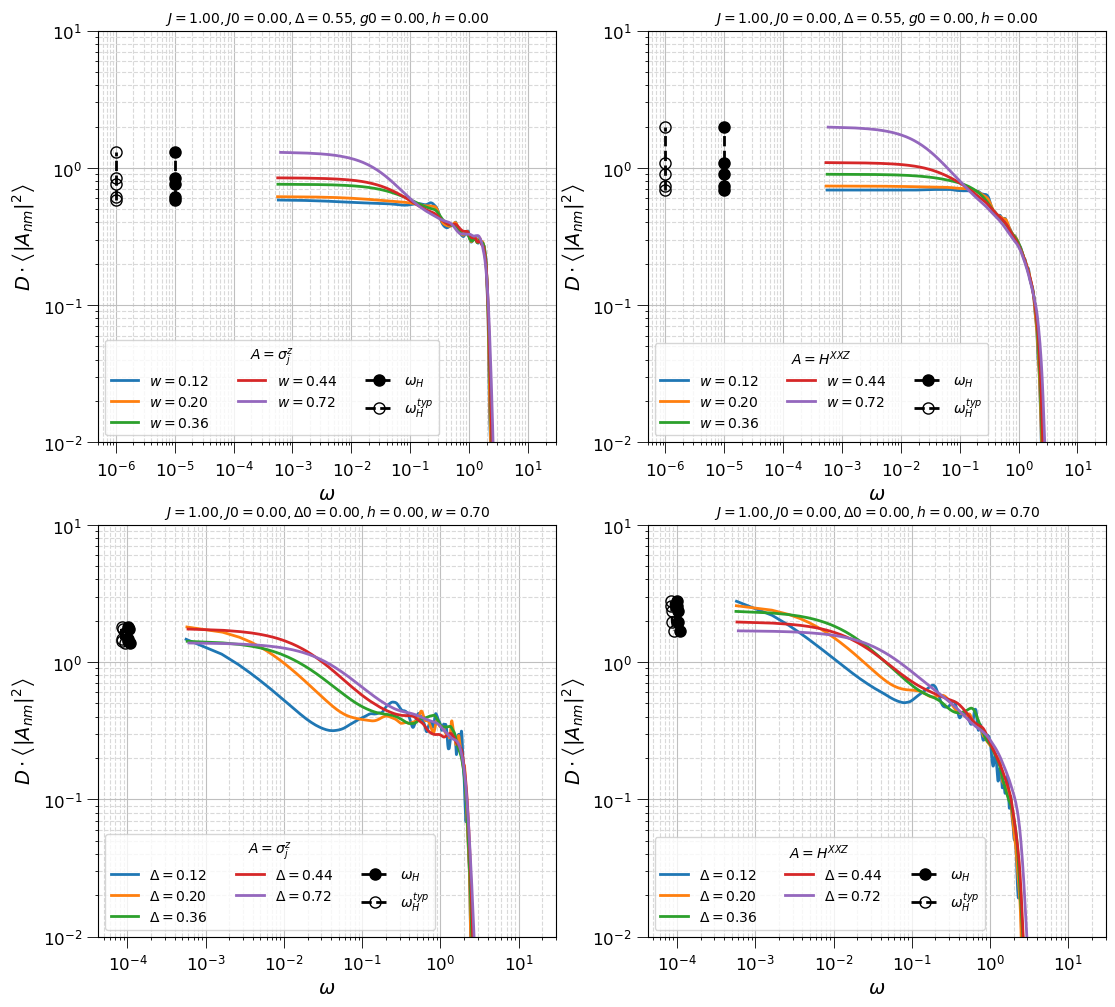

In [ ]:
reload_modules()
import scipy.integrate as integrate
x0 = 0.4
xend = 1.0
dx = 0.1
vals = hfun.get_scaling_array(user_settings, x0, xend, dx)
vals = np.array([0.12, 0.2, 0.36, 0.44, 0.72])
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots( nrows=2, ncols=2, figsize=(13,12), dpi = 100)

cut_off_large_omega = 0

def temporary_plot_spec(axis, operatorr, settings):
    wH = [];    LTA = []
    wH_typ = [];    val_at_typ = [];
    omegas = np.logspace(-5, 0, 1000)
    for x in vals:                    
        status, xdata, ydata, wHnow, wHtypnow = spec_fun.load_spectral(dir=spec_dir, 
                                                        settings=settings, 
                                                        parameter=x,
                                                        spec="spec",
                                                        func_x=lambda x, a: x,
                                                        operator = operatorr,
                                                        site = settings['site']
                                                        )
        if status:
            if cut_off_large_omega:
                ydata = np.array([ydata[i] for i in range(0,len(ydata)) if (xdata[i] < 3.0)])
                xdata = np.array([xdata[i] for i in range(0,len(xdata)) if (xdata[i] < 3.0)])
            ydata = ydata * (2**x / x if settings['scaling_idx'] == 0 else 2**cf.L / cf.L) # rescale by D                                                    
            if np.isnan(wHnow):
                wHnow = 1e-5
                wHtypnow = 1e-6
            p = axis.plot(xdata, ydata,label=hfun.key_title(x, settings), linewidth=2, markersize=6)
            "mean";     wH.append(wHnow);           idx = min(range(len(xdata)), key=lambda i: abs(xdata[i] - wHnow));     LTA.append(ydata[idx])
            "typical";  wH_typ.append(wHtypnow);    idx = min(range(len(xdata)), key=lambda i: abs(xdata[i] - wHtypnow));  val_at_typ.append(ydata[idx])

            "lorentzian only with cut off"
            if cut_off_large_omega:
                new_set_class = copy.deepcopy(cf.plot_settings)
                new_set_class.set_vs(settings['scaling'])
                new_set_class.set_scaling('L')
                tau_data = []
                status = False
                try :
                    tau_data = thouless.load(getattr(new_set_class, 'settings'))
                    status = True
                except OSError:
                    print("No Thouless data present")
                x_for_tau = []
                taus = []
                if status:    
                    idx = list(tau_data[0]).index(cf.L)
                    x_for_tau = tau_data[1][idx]
                    taus = tau_data[2][idx]
                idx = min(range(len(x_for_tau)), key=lambda i: abs(x_for_tau[i] - x))
                factor = 1
                tau = factor * taus[idx]
                norm = integrate.simpson(y=ydata, x=xdata)
                axis.plot(omegas, ydata[0] / (1 + (omegas * tau)**2 ), color=p[0].get_color(), linestyle='--')
    
    #axis.plot(omegas, 0.4 / (omegas)**0.5, linestyle='--', color='red', label=r"$\omega^{-0.5}$") 
    #axis.plot(omegas, 0.1 / (omegas)**0.75, linestyle='--', color='black', label=r"$\omega^{-0.75}$")        
    hfun.set_plot_elements(axis = axis, ylabel = "D\\cdot\\left\\langle|A_{nm}|^2\\right\\rangle", xlabel = "\\omega", settings=settings, font_size=12, set_legend=False, xlim=(None, None), ylim=(None, None))
    axis.set_xscale('log')
    axis.set_yscale('log')
    x_min = 0.5 * min(wH_typ)
    if cut_off_large_omega: axis.set_xlim(x_min, 3e0)
    else: axis.set_xlim(x_min, 3e1)
    axis.set_ylim(1e-2, 1e1)
    axis.grid(b=True, which='major', color='0.75', linestyle='-')
    axis.grid(b=True, which='minor', color='0.85', linestyle='--')
    #add_legend(axis=axis)
    
    axis.plot(wH, LTA, linestyle='--', marker='o', color='black', linewidth=2, markersize=8, label=r"$\omega_H$")
    axis.plot(wH_typ, val_at_typ, linestyle='--', marker='o', color='black', markerfacecolor='None', linewidth=2, markersize=8, label=r"$\omega_H^{typ}$")
    
    try:
        idx = (cf.operator_formuals[operatorr][2:]).index("=")
        leg = axis.legend(title=r"$A=$"+cf.operator_formuals[operatorr][0:idx] + "$", loc='lower left', ncol=3)
    except ValueError:
        leg = axis.legend(title=r"$A=$"+cf.operator_formuals[operatorr], loc='lower left', ncol=3)

    title = ""
    if (settings['vs_idx'] == 3 or settings['scaling_idx'] == 3) and cf.J0 == 0 and cf.g0 == 0 and cf.h != 0:
        title = hfun.remove_info(hfun.info_param(cf.params_arr), settings['vs'], settings['scaling'], 'w') + ',w=0.5h'
    else :
        title = hfun.remove_info(hfun.info_param(cf.params_arr), settings['vs'], settings['scaling'])
    if settings['vs_idx'] != 2 :
        try : 
            title = list(title);    title[title.index('g')] = hfun.var_name;   title = "".join(title) # g
        except ValueError:
                print("not found")
    axis.title.set_text(r"$%s$"%title[1:])
    axis.title.set_fontsize(10)

cf.set_params(_g=0.55)
temporary_plot_spec(axis=ax1, operatorr=0, settings=user_settings)
temporary_plot_spec(axis=ax2, operatorr=2, settings=user_settings)

cf.set_params(_w=0.7)
new_set_class = copy.deepcopy(cf.plot_settings)
new_set_class.set_scaling("g")
settings = getattr(new_set_class, 'settings')
temporary_plot_spec(axis=ax3, operatorr=0, settings=settings)
temporary_plot_spec(axis=ax4, operatorr=2, settings=settings)

### 1-panel single disorder

In [ ]:
w = 1.0
L = 14

status2, xdata2, ydata2, wHnow, wHtypnow = spec_fun.load_spectral(dir=spec_dir, 
                                                                    settings=user_settings, 
                                                                    parameter=x,
                                                                    spec="spec",
                                                                    normalise=True,
                                                                    operator=0
                                                                    )